# Setup

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Dropbox/Studie/S9/deep-learning/deeplearning-autumn-20') # Change with your path to the git repo
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from collections import OrderedDict

# Models

In [3]:
class StandardConv(nn.Module):
    def __init__(self, kernel_size=3, dropout=True):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride=1, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride=1, padding=kernel_size//2)

        if dropout:
            self.dropout1 = nn.Dropout2d(0.25)
            self.dropout2 = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(28*28//4*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        if self.dropout:
            x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        if self.dropout:
            x = self.dropout2(x)
        x = self.fc2(x)

        return x


class Conv(nn.Sequential):
    def __init__(
            self,
            kernel_size=3,
            convolutions=2,
            first_channels=32,
            dropout=True,
            input_size=28*28,
            input_kernels=1,
            linear_size=512,
            output_size=10,
            batch_norm=False
        ):
        layers = []
        in_channels = input_kernels
        out_channels = first_channels
        padding = kernel_size // 2
        size = input_size
        length = round(size ** 0.5)
        for i in range(convolutions):
            layers.append((
                f"cnn{i+1}",
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding)
            ))
            if batch_norm:
                layers.append((
                    f"conv_batch_norm{i+1}",
                    nn.BatchNorm2d(out_channels)
                ))
            layers.append((
                "relu{i+1}",
                nn.ReLU()
            ))
            layers.append((
                f"maxpool{i+1}",
                torch.nn.MaxPool2d(2)
            ))
            in_channels = out_channels
            out_channels = 2*out_channels
            length //= 2
            size = length ** 2
        if dropout:
            layers.append((
                "dropout1",
                nn.Dropout2d(0.25)
            ))
        layers.append((
            'flatten',
            torch.nn.Flatten()
        ))
        layers.append((
            f"linear",
            torch.nn.Linear(size * in_channels, linear_size)
        ))
        if batch_norm:
            layers.append((
                f"linear_batch_norm",
                nn.BatchNorm1d(linear_size)
            ))
        layers.append((
            "relu_linear",
            torch.nn.ReLU()
        ))
        if dropout:
            layers.append((
                "dropout2",
                nn.Dropout(0.5)
            ))
        layers.append((
            "output",
            torch.nn.Linear(linear_size, output_size)
        ))
        layers.append((
            "softmax",
            torch.nn.Softmax()
        ))
        super().__init__(OrderedDict(layers))



class SparseMaxPool2D(nn.Module):
    def __init__(self, kernel_size: int, sparsity: float):
        super().__init__()
        self.kernel_size = kernel_size
        self.maxpool = F.max_pool2d()
        self.sparsity = sparsity

    def forward(self, x):
        x =  F.max_pool2d(x, self.kernel_size)


class ConvSparse(nn.Sequential):
    def __init__(
        self,
        kernel_size=3,
        convolutions=2,
        conv_per_maxpool=1,
        first_channels=32,
        input_size=None,
        input_kernels=1,
        linear_size=512,
        output_size=10,
        linear_sparsity=0.8,
        cnn_sparsity=0.8,
        batch_norm=False
        ):
        layers = []
        in_channels = input_kernels
        out_channels = first_channels
        padding = kernel_size // 2
        width = int(input_size**0.5)
        size = input_size
        for i in range(convolutions):
            for j in range(conv_per_maxpool):
                i_ch = in_channels if j == 0 else out_channels
                layers.append((
                    f"cnn{i+1}-{j+1}",
                    nn.Conv2d(i_ch, out_channels, kernel_size, stride=1, padding=padding),
                ))
            layers.append((
                f"maxpool{i+1}",
                torch.nn.MaxPool2d(2)
            ))
            if batch_norm:
                layers.append((
                    f"batch_norm{i+1}",
                    torch.nn.BatchNorm2d(out_channels)
                ))
            layers.append((f"cnn_kwinner{i+1}", KWinners(1 - cnn_sparsity, dim=2)))
            in_channels = out_channels
            out_channels = 2*out_channels
            width //=2
            size = width ** 2
        layers.append((
            'flatten',
            torch.nn.Flatten()
        ))
        layers.append((
            f"linear",
            torch.nn.Linear(size * in_channels, linear_size)
        ))
        if batch_norm:
            layers.append((
                f"linear_batch_norm",
                nn.BatchNorm1d(linear_size)
            ))
        layers.append((
            "linear_kwinner",
            KWinners(1 - linear_sparsity, dim=1)))
        layers.append((
            "output",
            torch.nn.Linear(linear_size, output_size)
        ))
        super().__init__(OrderedDict(layers))


def k_winners(X, k, dim=1):
    values, ind = X.topk(k, dim=dim)
    return torch.zeros(X.shape, device=X.device).scatter_(dim, ind, values)


class KWinners(torch.nn.Module):
    def __init__(self, k, dim=1):
        super().__init__()
        self.k = k
        self.dim = dim

    def forward(self, x):
        old_shape = x.shape
        x = x.flatten(start_dim=self.dim)
        k = int(x.shape[-1] * self.k)
        return k_winners(x, k, dim=self.dim).reshape(old_shape)


class FullySparse(torch.nn.Module):
    def __init__(self, input_size=None, hidden=128, output_size=None, k=0.3):
        super().__init__()
        self.input_size = input_size
        self.hidden = hidden
        self.output_size = output_size
        self.k = k
        self.fc1 = torch.nn.Linear(input_size, hidden)
        self.k_winners = KWinners(self.k)
        self.fc2 = torch.nn.Linear(hidden, output_size)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.fc1(x) 
        x = self.k_winners(x)
        x = self.fc2(x)
        return x


# ================== Code from https://github.com/meliketoy/wide-resnet.pytorch/blob/master/networks/wide_resnet.py =====================
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)


def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)


class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut= nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out


class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10):
        super().__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(WideBasic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(WideBasic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(WideBasic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out 


class WideBasicSparse(nn.Module):
    def __init__(self, in_planes, planes, sparsity, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)
        self.k_winners = KWinners(1 - sparsity, dim=2)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut= nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.conv1(self.k_winners(self.bn1(x)))
        out = self.conv2(self.k_winners(self.bn2(out)))
        out += self.shortcut(x)

        return out


class WideResNetSparse(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=10, sparsity=0.0):
        super().__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(WideBasicSparse, nStages[1], n, sparsity, stride=1)
        self.layer2 = self._wide_layer(WideBasicSparse, nStages[2], n, sparsity, stride=2)
        self.layer3 = self._wide_layer(WideBasicSparse, nStages[3], n, sparsity, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)
        self.k_winners = KWinners(1 - sparsity, dim=2)

    def _wide_layer(self, block, planes, num_blocks, sparsity, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, sparsity, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def set_sparsity(self, sparsity):
        for layer in [self.layer1, self.layer2, self.layer3]:
            for mod in layer:
                mod.k_winners.k = 1 - sparsity
        self.k_winners.k = 1 - sparsity

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.k_winners(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out 


# Datasets

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10


nn_range2 = transforms.Normalize(0.5, 0.5)

root = 'datasets'

class RandomNoiseNormalWhite:
    def __init__(self, p):
        self.p = p

    def __call__(self, data):
        n = data.shape[0]
        t = data.reshape(n, -1)
        mean, std = torch.std(t.float(), 1), torch.mean(t.float(), 1)
        mx = torch.max(data)
        values = torch.min(mean + 2*std, torch.full(mean.shape, mx))
        r = torch.rand(data.shape) 
        return data * (r > self.p) + values.reshape(n, 1, 1) * (r <= self.p)
    
    def __str__(self):
        return f"{type(self).__name__}({self.p})"


class RandomNoiseUniform:
    def __init__(self, p):
        self.p = p

    def __call__(self, data):
        mn = torch.min(data)
        mx = torch.max(data)
        r1 = mn + torch.rand(data.shape) * (mx - mn)
        r2 = torch.rand(data.shape)
        return data * (r2 > self.p) + r1 * (r2 <= self.p)
    
    def __str__(self):
        return f"{type(self).__name__}({self.p})"

    
class RandomNoiseWhite:
    def __init__(self, p):
        self.p = p

    def __call__(self, data):
        mx = torch.max(data)
        r = torch.rand(data.shape)
        return data * (r > self.p) + (r <= self.p) * mx
    
    def __str__(self):
        return f"{type(self).__name__}({self.p})"


class RandomNoiseBlack:
    def __init__(self, p):
        self.p = p

    def __call__(self, data):
        mn = torch.min(data)
        r = torch.rand(data.shape)
        return data * (r > self.p) + (r <= self.p) * mn 
    
    def __str__(self):
        return f"{type(self).__name__}({self.p})"


def make_dataset(f, split=True, train=True, numpy=False, trans=[]):
    t = transforms.Compose(trans)
    if split:
        train = f(root, train=True, transform=t)
        test = f(root, train=False, transform=t)
        res = (train, test)
    else:
        res = f(root, train=train, transform=t)

    if numpy:
        if isinstance(res, tuple):
            return tuple((res[i].data.numpy(), res[i].targets.numpy()) for i in [0,1])
        else:
            return (res.data.numpy(), res.targets.numpy())
    else:
        return res


def mnist(split=True, train=True, numpy=False, transforms=[]):
    return make_dataset(MNIST, split=split, train=train, numpy=numpy, trans=transforms)


def fashion_mnist(split=True, train=True, numpy=False, transforms=[]):
    return make_dataset(FashionMNIST, split=split, train=train, numpy=numpy, trans=transforms)


def cifar10(split=True, train=True, numpy=False, transforms=[]):
    return make_dataset(CIFAR10, split=split, train=train, numpy=numpy, trans=transforms)


# Attacks

In [5]:
def fgsm(model, loss, images, labels, epsilon=0.0):
    if epsilon == 0.0:
        return images
    images.requires_grad = True
    outputs = model(images)
    loss_ = loss(outputs, labels)

    model.zero_grad()
    loss_.backward() 
        
    peturbed = images + epsilon * images.grad.data.sign()
    peturbed = torch.clamp(peturbed, -1, 1)
    return peturbed    


class FGSM:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon

    def __call__(self, model, loss, images, labels):
        return fgsm(model, loss, images, labels, epsilon=self.epsilon)


def project(X, Y, epsilon):
    X_Y = X-Y
    d = X.device
    diff = X_Y.flatten(start_dim=1)
    norm = torch.norm(diff, dim=1)
    max_ = torch.Tensor([1.0])
    if norm.device.type == 'cuda':
        max_ = max_.cuda(norm.device) 
    norm = torch.max(max_, norm / epsilon)
    diff_normalized = diff / norm.reshape(-1, 1)
    return Y + diff_normalized.reshape(X.shape)


def bim(model, loss, images, labels, alpha=1/255.0, epsilon=1.0, steps=1):
    if epsilon == 0:
        return images
    epsilon *= images[0].flatten().shape[0] ** 0.5
    images_adversarial = torch.clone(images)
    for _ in range(steps):
        images_adversarial = project(fgsm(model, loss, images_adversarial.detach().clone(), labels, epsilon=alpha), images, epsilon)
    return images_adversarial


class BIM:
    def __init__(self, alpha=1/255.0, epsilon=0.3, steps=50):
        self.alpha = alpha
        self.epsilon = epsilon
        self.steps = steps

    def __call__(self, model, loss, images, labels):
        return bim(model, loss, images, labels, alpha=self.alpha, epsilon=self.epsilon, steps=self.steps)


# Load model, optimizer and stuff from config

In [6]:
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
import os
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional
import json
from torch.utils.data import DataLoader
import math


class ConfigException(Exception):
    def __init__(self, arg_name, arg):
        super().__init__(f"'{arg_name}' config argument was {arg}")


default_conf = {
    'script': 'train',
    'start_epoch': 1
}


class Runner:
    def __init__(self, config, device=torch.device('cpu')):
        self.config = config
        self.device = device

        self.model = None
        self.optimizer = None
        self.lr_scheduler = None
        self.loss = None
        self.attack = None
        self.epoch_scripts = []


def prune_dict(d, prune=['type']):
    return {k: v for (k,v) in d.items() if k not in prune}


def load_model(r: Runner):
    m_conf = r.config['model']
    r.config.update({"model": m_conf})
    if 'pretrained' in m_conf:
      model = m_conf['pretrained'] 
      model.to(r.device)
      r.model = model
      return

    t = m_conf['type']
    m_conf = prune_dict(m_conf, prune=['type', 'parameters'])
    if t == "standard_conv":
        model = StandardConv(**m_conf)
    elif t == 'conv':
        model = Conv(**m_conf)
    elif t == 'sparse_cnn':
        model = SparseCNN(**m_conf)
    elif t == 'conv_sparse':
        model = ConvSparse(**m_conf)
    elif t == 'wide_resnet':
        model = WideResNet(**m_conf)
    elif t == 'wide_resnet_sparse':
        model = WideResNetSparse(**m_conf)
    else:
        raise ConfigException('model.type', t)

    model.to(r.device)
    r.model = model


def load_loss(r: Runner):
    t = r.config['loss']
    if t == 'cross_entropy':
        r.loss = torch.nn.CrossEntropyLoss() 
    else:
        raise ConfigException('loss', config)


def load_optimizer(r: Runner):
    if 'optimizer' not in r.config:
        return
    
    o_conf = r.config['optimizer']
    t = o_conf['type']
    if t == 'adam':
        optimizer = torch.optim.Adam(r.model.parameters(), **prune_dict(o_conf, prune=['type', 'parameters']))
    elif t == 'sgd':
        optimizer = torch.optim.SGD(r.model.parameters(), **prune_dict(o_conf, prune=['type', 'parameters']))
    else:
        raise ConfigException('optimizer.type', t)
    
    r.optimizer = optimizer 
    r.config.update({'optimizer': o_conf})
    

def load_data(data_conf, batch_size, is_train=False):
    noise = data_conf.get("noise", {})
    t = noise.get("type", None)
    p = noise.get("p", None)
    if t is not None:
        if t == 'normal_white':
            noise = RandomNoiseNormalWhite
        elif t == 'uniform':
            noise = RandomNoiseUniform
        elif t == 'white':
            noise = RandomNoiseWhite
        elif t == 'black':
            noise = RandomNoiseBlack
        else:
            raise ConfigException('noise.type', t)
        trans = [torchvision.transforms.ToTensor(), noise(p), nn_range2]
    else:
        trans = [torchvision.transforms.ToTensor(), nn_range2]
    
    dataset = data_conf['type']
    if dataset == 'mnist':
        data = mnist(transforms=trans, split=False, train=is_train)
    elif dataset == 'fashion_mnist':
        data = fashion_mnist(transforms=trans, split=False, train=is_train)
    elif dataset == 'cifar10':
        data = cifar10(transforms=trans, split=False, train=is_train)
    else:
        raise ConfigException('data.type', dataset)
    amount = data_conf.get("amount", None)
    if isinstance(amount, int):
        data.data = data.data[:amount]
        data.targets = data.targets[:amount]
    return DataLoader(data, batch_size=batch_size, shuffle=True)


def load_attack(type_: str, **kwargs):
    if type_ == 'fgsm':
        return FGSM(**kwargs)
    if type_ == 'bim':
        return BIM(**kwargs)
    else:
        raise ConfigException("attack.type", type_)


def load_epoch_scripts(r: Runner):
    if not 'epoch_scripts' in r.config:
        return
    for script in r.config['epoch_scripts']:
        t = script['type']
        func = None
        if t == 'set_sparsity':
            func = scripts.set_sparsity
        else:
            raise ConfigException(f"config.epoch_scripts had {t} as argument.")
        r.epoch_scripts.append(lambda epoch, r: func(epoch, r, **prune_dict(script)))




# Training and Eval 

In [21]:
from collections import defaultdict

def run_runner(r: Runner):
    load_model(r)
    load_optimizer(r)
    load_loss(r)
    load_epoch_scripts(r)
    batch_size = r.config['batch_size']
    
    scripts = r.config['script'] if isinstance(r.config['script'], list) else [r.config['script']]
    results = []
    for script in scripts: 
        if script == 'train':
            results.append(train(r))
        elif script == 'test': 
            results.append(test(r))
        elif script == 'noise_experiment':
            results.append(noise_experiment(r))
        elif script == 'attack':
            results.append(attack(r))
    return results


def attack(r: Runner):
    batch_size = r.config['batch_size']
    loader = load_data(r.config['data']['test'], batch_size, is_train=False)
    a_conf = r.config['attack']
    accuracies = []
    logging = defaultdict(dict)
    for arg in a_conf['args']:
        attack_ = load_attack(a_conf['type'], **arg)
        n = 10
        running_loss = 0.0
        correct = 0
        all_preds = []
        all_true = []
        num = 0

        key, value = next(iter(arg.items()))
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(r.device), labels.to(r.device)
            num += inputs.shape[0]

            pertubed = attack_(r.model, r.loss, inputs, labels)

            outputs = r.model(pertubed)
            loss = r.loss(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += torch.sum(labels == preds).item()
            if (i+1) % n == 0:
                print(f"\r{key}={value}: [{i+1}/{len(loader)}]: loss: {running_loss/num:.5f}, acc: {correct / num:.4f}" + " "*10, end='')

        if len(loader) % n != 0:
            print(f"\r{key}={value}: [{i+1}/{len(loader)}]: loss: {running_loss/num:.5f}, acc: {correct / num:.4f}" + " "*10, end='')
        logging[arg['epsilon']]['loss'] = running_loss/num
        logging[arg['epsilon']]['acc'] = correct/num
    return logging
        

def labels_from_loader(loader):
    min_label = float('inf')
    max_label = 0
    for _, labels in loader: 
        min_label = torch.min(labels).item()
        max_label = torch.max(labels).item()
    return list(range(min_label, max_label+1))


def noise_experiment(r: Runner):
    logging = defaultdict(lambda: defaultdict(dict))

    noise_conf = r.config['data']['noise_experiment']
    for i, p in enumerate(noise_conf['noise']['p']):
        for noise_type in noise_conf['noise']['type']:
            conf = {**noise_conf}
            conf['noise'] = {
                    'type': noise_type,
                    'p': p
                }
            data_loader = load_data(
                conf,
                r.config['batch_size'],
                is_train=False
            )
            labels = labels_from_loader(data_loader)
            true, preds, acc, loss_ = run_epoch(r, data_loader, 1, False)
            logging[noise_type][p]['acc'] = acc
            logging[noise_type][p]['scores'] = round(len(preds) * acc)
    return logging


def test(r: Runner):
    data_loader = load_data(r.config['data']['test'], r.config['batch_size'], is_train=False)
    labels = labels_from_loader(data_loader)
    true, preds, acc, loss = run_epoch(r, data_loader, 1, False)
    return {'acc': acc, 'loss': loss}
        

def train(r: Runner):
    batch_size = r.config['batch_size']
    train_loader = load_data(r.config['data']['train'], batch_size, is_train=True)
    test_loader = load_data(r.config['data']['test'], batch_size, is_train=False)
    labels = labels_from_loader(test_loader)
    epochs = r.config['epochs']

    logging = defaultdict(dict)

    n = 1
    best_acc = 0 

    for epoch in range(1, 1 + epochs):
        print(f"========== Epoch {epoch}/{epochs} ==========")
        for script in r.epoch_scripts:
            script(epoch, r)

        train_true, train_preds, train_acc, train_loss = run_epoch(r, train_loader, epoch, True)
        test_true, test_preds, test_acc, test_loss = run_epoch(r, test_loader, epoch, False)
        logging[epoch] = {
            'train_acc': train_acc,
            'train_loss': train_loss,
            'test_acc': test_loss,
            'test_loss': test_loss
        }
        print('\n')

    return logging    
    

def run_epoch(r: Runner, data_loader, epoch, train):
    def inner(text):
        nonlocal r, data_loader, epoch
        n = 1
        running_loss = 0.0
        correct = 0
        all_preds = []
        all_true = []
        num = 0
    
        for i, (inputs, labels) in enumerate(data_loader, 0):
            inputs, labels = inputs.to(r.device), labels.to(r.device)

            if r.optimizer:
                r.optimizer.zero_grad()

            outputs = r.model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += torch.sum(labels == preds).item()
            num += labels.shape[0]

            loss = r.loss(outputs, labels)
            if r.optimizer and train:
                loss.backward()
                r.optimizer.step()
                if r.lr_scheduler:
                    r.lr_scheduler.step()

            running_loss += loss.item()
            if (i+1) % n == 0:
                print(f"\r{text}: [{i+1}/{len(data_loader)}]: loss: {running_loss/num:.5f}, acc: {correct / num:.4f}" + " "*10, end='')

            all_true.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

        if len(data_loader) % n != 0:
            print(f"\r{text}: [{i+1}/{len(data_loader)}]: loss: {running_loss/num:.5f}, acc: {correct / num:.4f}" + " "*10, end='')
        print() 
        true = np.concatenate(all_true)
        preds = np.concatenate(all_preds)
        return true, preds, correct/num, running_loss/num

    if train:
        r.model.train()
        text = 'train'
        return inner(text)
    else:
        r.model.eval()
        text = 'test'
        with torch.no_grad():
            return inner(text)

# Noise Experiments


In [33]:
noise_types = ['uniform', 'normal_white', 'white', 'black']
noise_levels = [round(i*0.05, 3) for i in range(1,11)]
device = torch.device('cuda') 

config = {
    'script': 'train',
    'data': {
        'train': {
            'type': 'mnist',
            'amount': 'all'
        },
        'test': {
            'type': 'mnist',
            'amount': 'all'
        },
        'noise_experiment': {
            'type': 'mnist',
            'amount': 'all',
            'noise': {
                'type': noise_types,
                'p': noise_levels
            }
        }
    },
    'model': {
          "type": "conv",
          "batch_norm": True,
          "convolutions": 2,
          "dropout": True,
          "input_kernels": 1,
          "input_size": 784,
          "kernel_size": 3,
          "linear_size": 400,
    },
    'optimizer': {
        'type': 'adam',
        'lr': 0.0045
    },
    'epochs': 10,
    'loss': 'cross_entropy',
    'batch_size': 64
}

In [34]:
import copy
import json

def set_dataset(config, dataset):
  config['data']['train']['type'] = dataset
  config['data']['test']['type'] = dataset
  config['data']['noise_experiment']['type'] = dataset


def train_models(dataset, dense_model_config, dense_optimizer_config, sparse_model_config, sparse_optimizer_config, config):
  set_dataset(config, dataset)
  config['script'] = 'train'

  models = {}

  print("Training dense")
  config['model'] = copy.deepcopy(dense_model_config)
  config['optimizer'] = copy.deepcopy(dense_optimizer_config)
  r = Runner(config, device=device)
  run_runner(r)
  models['dense'] = r.model

  print("Training sparse")
  config['model'] = copy.deepcopy(sparse_model_config)
  config['optimizer'] = copy.deepcopy(sparse_optimizer_config)
  r = Runner(config, device=device)
  run_runner(r)
  models['sparse'] = r.model

  models['noise'] = {}
  for noise_type in noise_types:
    print("Training", noise_type)
    config['data']['train']['noise'] = {
        'type': noise_type,
        'p': 0.5
    }
    config['model'] = copy.deepcopy(dense_model_config)
    r = Runner(config, device=device)
    run_runner(r)
    models['noise'][noise_type] = r.model

  return models


def test_models_on_noise(dataset, models, config):
  set_dataset(config, dataset)
  results = {}
  config['script'] = 'noise_experiment'

  print("Testing on dense")
  config['model'] = {'pretrained': models['dense']}
  r = Runner(config, device=device)
  result, = run_runner(r)
  results['dense'] = result
  print()

  print("Testing on sparse")
  config['model'] = {'pretrained': models['sparse']}
  r = Runner(config, device=device)
  result, = run_runner(r)
  results['sparse'] = result
  print()

  results['noise'] = {}
  for noise_type in models['noise']:
    print("Testing on", noise_type)
    config['model'] = {'pretrained': models['noise'][noise_type]}
    result, = run_runner(r)
    results['noise'][noise_type] = result
    print()
  
  return results
import json

def plot_noise_results(results):
  fig, axes = plt.subplots(2,2, figsize=(12,12))

  for i, noise_type in enumerate(noise_types):
    ax = axes[i%2, i//2]

    xs, ys = [], []
    for (k,v) in results['dense'][noise_type].items():
      xs.append(k)
      ys.append(v['acc'])
    ax.plot(xs, ys, '-', label='dense', linewidth=1.5)

    xs, ys = [], []
    for (k,v) in results['sparse'][noise_type].items():
      xs.append(k)
      ys.append(v['acc'])
    ax.plot(xs, ys, '-', label='sparse', linewidth=1.5)

    for noise in noise_types:
      xs, ys = [], []
      for (k,v) in results['noise'][noise][noise_type].items():
        xs.append(k)
        ys.append(v['acc'])
      ax.plot(xs, ys, '--', label=noise, linewidth=1.0)
    
    ax.set_title(noise_type)
    ax.set_xlabel("Noise Level")
    ax.set_ylabel("Accuracy")
  plt.tight_layout()
  plt.legend()
  plt.plot()

In [35]:
# Noise Experiments MNIST
config['epochs'] = 1
config['batch_size'] = 64

dense_model = {
    "type": "conv",
    "batch_norm": True,
    "convolutions": 2,
    "dropout": True,
    "input_kernels": 1,
    "input_size": 784,
    "kernel_size": 3,
    "linear_size": 400,
}
dense_optimizer = {
    'type': 'adam',
    'lr': 0.0045
}
sparse_model = {
  'type': 'conv_sparse',
  'input_size': 784,
  'linear_size': 700,
  'linear_sparsity': 0.8,
  'cnn_sparsity': 0.75,
}
sparse_optimizer = {
    'type': 'sgd',
    'lr': 0.1,
    'momentum': 0.9
}
mnist_models = train_models('mnist', dense_model, dense_optimizer, sparse_model, sparse_optimizer, config)
mnist_noise_results = test_models_on_noise('mnist', mnist_models, config)
plot_noise_results(mnist_noise_results)

Training dense
========== Epoch 1/1 ==========
train: [13/938]: loss: 0.02921, acc: 0.6442          

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train: [284/938]: loss: 0.02415, acc: 0.9267          

KeyboardInterrupt: ignored

In [16]:
# Noise Experiments FashionMNIST
config['epochs'] = 1
config['batch_size'] = 64

dense_model = {
    "type": "conv",
    "batch_norm": True,
    "convolutions": 2,
    "dropout": True,
    "input_kernels": 1,
    "input_size": 784,
    "kernel_size": 3,
    "linear_size": 470,
}
dense_optimizer = {
    'type': 'adam',
    'lr': 0.00016
}

sparse_model = {
  'type': 'conv_sparse',
  'conv_per_maxpool': 2,
  'convolutions': 2,
  'input_size': 784 ,
  'linear_size': 200,
  'linear_sparsity': 0.82,
  'cnn_sparsity': 0.76,
}
sparse_optimizer = {
    'type': 'adam',
    'lr': 0.00032,
}
fashion_models = train_models('fashion_mnist', dense_model, dense_optimizer, sparse_model, sparse_optimizer, config)
fashion_noise_results = test_models_on_noise('fashion_mnist', fashion_models, config)
plot_noise_results(fashion_noise_results)

Training dense
========== Epoch 1/1 ==========
train: [9/16]: loss: 0.03461, acc: 0.3125          

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train: [16/16]: loss: 0.03425, acc: 0.4110          
test: [16/16]: loss: 0.03518, acc: 0.3800          


Training sparse
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03447, acc: 0.3050          
test: [16/16]: loss: 0.04489, acc: 0.1100          


Training uniform
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03378, acc: 0.4440          
test: [16/16]: loss: 0.03180, acc: 0.6140          


Training normal_white
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03310, acc: 0.4810          
test: [16/16]: loss: 0.03454, acc: 0.3650          


Training white
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03303, acc: 0.4640          
test: [16/16]: loss: 0.03237, acc: 0.6050          


Training black
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03320, acc: 0.4350          
test: [16/16]: loss: 0.03358, acc: 0.4560          


Testing on dense
test: [2/2]: loss: 0.04457, acc: 0.3400          
test: [2/2]: loss: 0.04483, acc: 0.2600       

In [17]:
# Noise Experiments FashionMNIST
config['epochs'] = 1
config['batch_size'] = 64

dense_model = {
  "depth": 28,
  "dropout_rate": 0.4,
  "num_classes": 10,
  "type": "wide_resnet",
  "widen_factor": 10
}
dense_optimizer = {
    'type': 'sgd',
    'lr': 0.1,
    'momentum': 0.9
}

sparse_model = {
  "depth": 28,
  "num_classes": 10,
  "sparsity": 0.7,
  "type": "wide_resnet_sparse",
  "widen_factor": 10
}
sparse_optimizer = {
    'type': 'sgd',
    'lr': 0.1,
    'momentum': 0.9
}
cifar10_models = train_models('cifar10', dense_model, dense_optimizer, sparse_model, sparse_optimizer, config)
cifar10_noise_results = test_models_on_noise('cifar10', cifar10_models, config)
plot_noise_results(cifar10_noise_results)

Training dense
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03871, acc: 0.1420          
test: [16/16]: loss: 0.48893, acc: 0.1720          


Training sparse
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03765, acc: 0.1610          
test: [16/16]: loss: 0.04698, acc: 0.1120          


Training uniform
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03838, acc: 0.1430          
test: [16/16]: loss: 0.80945, acc: 0.1210          


Training normal_white
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03901, acc: 0.1950          
test: [16/16]: loss: 0.08128, acc: 0.1680          


Training white
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03906, acc: 0.1570          
test: [16/16]: loss: 0.06705, acc: 0.1450          


Training black
========== Epoch 1/1 ==========
train: [16/16]: loss: 0.03867, acc: 0.1550          
test: [16/16]: loss: 0.33554, acc: 0.1410          


Testing on dense
test: [2/2]: loss: 0.59127, acc: 0.2000          

# Attack Experiments

In [31]:
def attack_experiment(dataset, models, config):
  set_dataset(config, dataset)
  config['script'] = 'attack'
  results = {}

  print("Attack dense")
  model = models['dense']
  config['model'] = {'pretrained': model}
  r = Runner(config, device=device)
  result, = run_runner(r)
  results['dense'] = result

  print("Attack sparse")
  model = models['sparse']
  config['model'] = {'pretrained': model}
  r = Runner(config, device=device)
  result, = run_runner(r)
  results['sparse'] = result

  results['noise'] = {}
  for noise in models['noise']:
    print("Attack", noise)
    model = models['noise'][noise]
    config['model'] = {'pretrained': model}
    r = Runner(config, device=device)
    result, = run_runner(r)
    results['noise'][noise] = result

  return results


def run_bim(dataset, models, config):
  attack = {
      'type': 'bim',
      'args': [{
          'epsilon': round(i*0.01, 3),
          'alpha': 1.0/255,
          'steps': int(i*0.01 * 255) + 5
      } for i in range(1,5)]
  }
  config['attack'] = attack
  return attack_experiment(dataset, models, config)


def run_fgsm(dataset, models, config):
  attack = {
      'type': 'fgsm',
      'args': [
        {'epsilon': round(0.05*i, 3)} for i in range(1,11)
      ]
  }
  config['attack'] = attack
  return attack_experiment(dataset, models, config)


def run_attacks(dataset, models, config):
  results = {}
  print("FGSM")
  results['fgsm'] = run_fgsm(dataset, models, config)
  print("BIM")
  results['bim'] = run_bim(dataset, models, config)
  return results


def plot_attacks(results):
  fig, axes = plt.subplots(2, figsize=(12,12))

  def plot_single(ax, result):
    xs, ys = [], []
    for k,v in result['dense'].items():
      xs.append(k)
      ys.append(v['acc'])
    ax.plot(xs, ys, '-', linewidth=1.5, label='dense')

    xs, ys = [], []
    for k,v in result['sparse'].items():
      xs.append(k)
      ys.append(v['acc'])
    ax.plot(xs, ys, '-', linewidth=1.5, label='sparse')

    for noise in result['noise']:
      xs, ys = [], []
      for k,v in result['noise'][noise].items():
        xs.append(k)
        ys.append(v['acc'])
      ax.plot(xs, ys, '--', linewidth=1, label=noise)
    
  plot_single(axes[0], results['fgsm'])
  plot_single(axes[1], results['bim'])
  axes[0].set_title("FGSM")
  axes[1].set_title("BIM")

  plt.tight_layout()
  plt.legend()
  plt.plot()

FGSM
Attack dense
epsilon=0.05: [10/16]: loss: 0.02826, acc: 0.6922          

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epsilon=0.5: [16/16]: loss: 0.03648, acc: 0.1670          Attack sparse
epsilon=0.5: [16/16]: loss: 0.20417, acc: 0.0900          Attack uniform
epsilon=0.5: [16/16]: loss: 0.03727, acc: 0.1430          Attack normal_white
epsilon=0.5: [16/16]: loss: 0.03683, acc: 0.1610          Attack white
epsilon=0.5: [16/16]: loss: 0.03843, acc: 0.0330          Attack black
epsilon=0.5: [16/16]: loss: 0.03495, acc: 0.3130          BIM
Attack dense
epsilon=0.04: [16/16]: loss: 0.02926, acc: 0.6700          Attack sparse
epsilon=0.04: [16/16]: loss: 0.15395, acc: 0.1630          Attack uniform
epsilon=0.04: [16/16]: loss: 0.03322, acc: 0.3680          Attack normal_white
epsilon=0.04: [16/16]: loss: 0.03493, acc: 0.2720          Attack white
epsilon=0.04: [16/16]: loss: 0.03621, acc: 0.1700          Attack black
epsilon=0.04: [16/16]: loss: 0.03053, acc: 0.5720          FGSM
Attack dense
epsilon=0.5: [16/16]: loss: 0.03669, acc: 0.1810          Attack sparse
epsilon=0.5: [16/16]: loss: 0.05014, acc:

KeyboardInterrupt: ignored

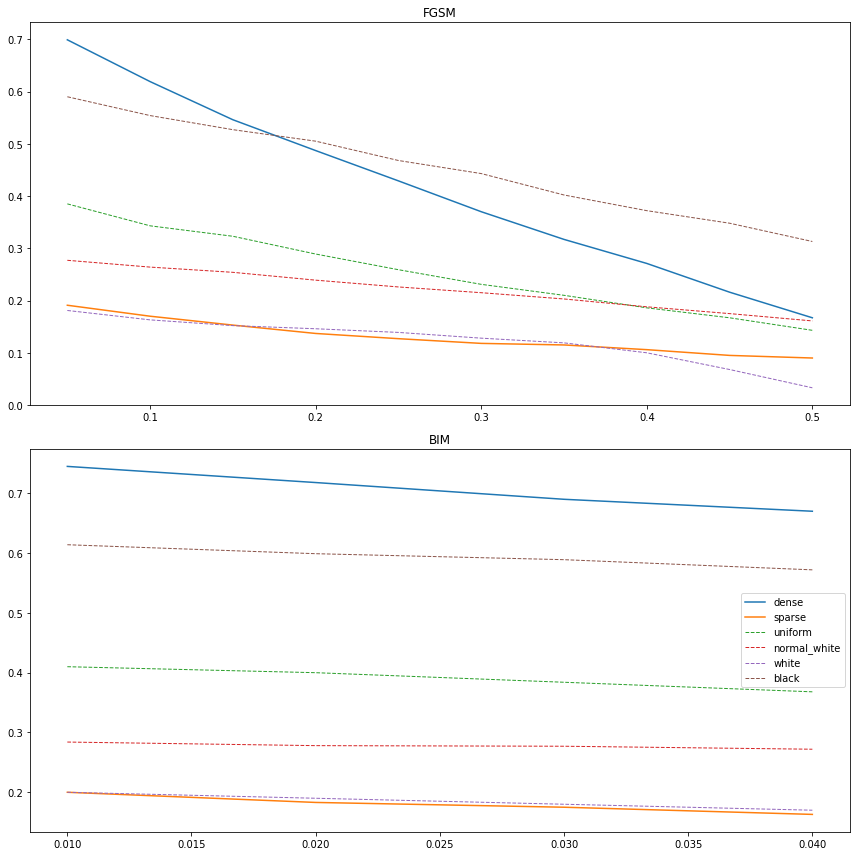

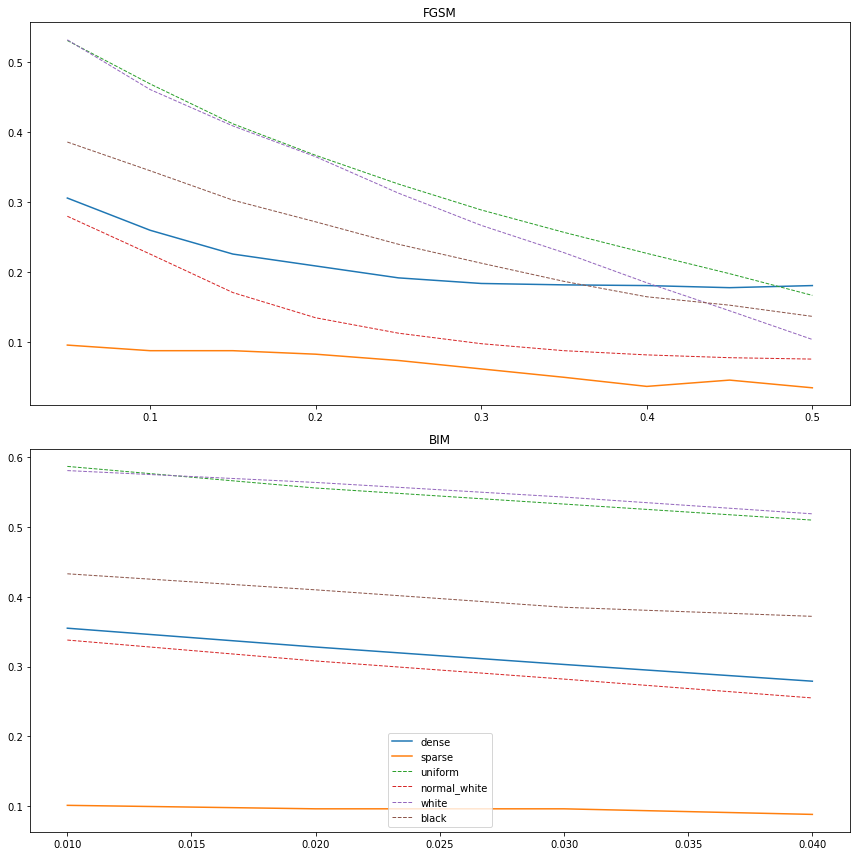

In [32]:
# Attacks
mnist_attack_results = run_attacks('mnist', mnist_models, config)
plot_attacks(mnist_attack_results)

fashion_attack_results = run_attacks('fashion_mnist', fashion_models, config)
plot_attacks(fashion_attack_results)

cifar10_attack_results = run_attacks('cifar10', cifar10_models, config)
plot_attacks(cifar10_attack_results)